# Volume change in density space

In [1]:
# Don't display filter warnings
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import xarray as xr
import os
import glob

from sklearn.metrics import r2_score
from dask.diagnostics import ProgressBar

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import sys
sys.path.append('../scripts')
from preprocessing import preprocessing
from plot import hovmoeller

### Loading and preprocessing data

In [3]:
mod = 'ESM4' # CM4, ESM4
exp = 'control' # control, antwater, stress, antwaterstress
mem = 201 # 251, 290, 332 (CM4) / 101, 151, 201 (ESM4)
head = '%s_%s'%(mod,exp) if exp=='control' else '%s_%s_%s'%(mod,exp,str(mem))

In [4]:
outdir='/scratch/gpfs/jt7058/GFDL/fafmip/netcdf/'
rootdir = '/scratch/gpfs/jt7058/GFDL/fafmip/raw/'
if mod=='CM4':
    subdir = 'CM4_piControl_C'
elif mod=='ESM4':
    subdir = 'ESM4_piControl_D'
pp = 'ocean_annual_rho2'
fafdir = '%s_faf%s_%s'%(subdir,exp,str(mem) if mod=='CM4' else str(mem))
full_path = os.path.join(rootdir,subdir,pp) if exp=='control' else os.path.join(rootdir,fafdir,pp)
print(full_path)

/scratch/gpfs/jt7058/GFDL/fafmip/raw/ESM4_piControl_D/ocean_annual_rho2


In [5]:
vars_ds = xr.open_mfdataset(full_path+'/'+pp+'.*.*.nc',use_cftime=True, 
                       drop_variables=['average_DT','average_T1','average_T2'])

In [6]:
print(vars_ds.dims)

Frozen({'time': 200, 'nv': 2, 'rho2_i': 36, 'rho2_l': 35, 'yq': 576, 'xh': 720, 'yh': 576})


In [7]:
pp = 'ocean_monthly'

if subdir[:3] == 'CM4':
    grid_ds = xr.open_dataset(rootdir+'CM4_piControl_C/'+pp+'/'+pp+'.static.nc')
elif subdir[:3] == 'ESM':
    grid_ds = xr.open_dataset(rootdir+'ESM4_piControl_D/'+pp+'/'+pp+'.static.nc')
else:
    print('grid is not available for '+subdir)

In [8]:
ds = preprocessing(vars_ds, grid_ds, decode_times=False, verbose=False)

### Subselect data for Southern Ocean (south of 30S)

In [9]:
# Isolate Southern Ocean
#north = -65.8
#north = -58.0
north = -30.0

# Isolate Southern Ocean
ds_so = ds.drop_dims('nv').where(ds.lat<north,drop=True)
ds_so['time_bnds'] = ds.time_bnds

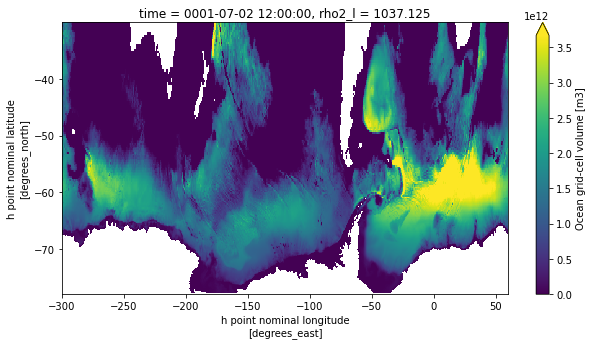

In [10]:
fig, ax = plt.subplots(figsize=(10,5))

ds_so.volcello[0,-3].plot(ax=ax,robust=True)

### Define time periods for each run

In [9]:
if mod=='CM4':
    if exp=='control':
        yr_st,yr_ed = '0281','0380'
    else:
        yr_st,yr_ed = '0051','0070'
elif mod=='ESM4':
    if exp=='control':
        yr_st,yr_ed = '0121','0220'
    elif mem==101:
        yr_st,yr_ed = '0151','0170'
    else:
        yr_st,yr_ed = '0051','0070'
        
print(yr_st,yr_ed)

0121 0220


### Load WMT and SMOC for comparison

In [12]:
north_str = '300S'
#dset = '_southof%s_swmt_'%north
dset = '_southof%s_swmt_decomposed_'%north_str
lstr = 'sigma2'
dl = '005'

ddict = {}
for var in ['swmt','psi']:
    if var == 'swmt':
        files = glob.glob(outdir+head+'_so_*'+dset+'%s_%s.nc'%(lstr,dl))
    elif var == 'psi':
        files = glob.glob(outdir+head+'_global_*_moc_rho2_online_lores.nc')
        
    if len(files)>1:
        print('WARNING: More than one file. Please specify.')
        print('Loading '+files[0])
    elif len(files)==0:
        print('ERROR: No file available for '+var+' in '+mod+'-'+exp)
        continue
        
    ddict[var] = xr.open_dataset(files[0])

### Volume in density space

In [13]:
print(str(ds.time.values[0])[:10],'to',str(ds.time.values[-1])[:10])

0001-07-02 to 0100-07-02


In [14]:
with ProgressBar():
    vol_rho2 = ds_so.volcello.sum(dim=['x','y']).load()

[########################################] | 100% Completed |  8.5s


In [15]:
fname = head+'_so_%sto%s_vol_rho2_online_lores.nc'\
        %(str(vol_rho2.time.dt.year[0].values).rjust(4, '0'),
          str(vol_rho2.time.dt.year[-1].values).rjust(4, '0'))
print('Saving to file:', fname)
vol_rho2.reset_coords(drop=True).to_dataset().to_netcdf(outdir+fname, format='NETCDF4')

Saving to file: ESM4_antwaterstress_201_so_0001to0100_vol_rho2_online_lores.nc


In [16]:
#vol_rho2 = xr.open_dataset(outdir+'CM4_stress_290_so_0001to0070_vol_rho2_online_lores.nc').volcello
vol_rho2 = xr.open_dataset(outdir+fname).volcello

In [17]:
vol_rho2['sigma2'] = vol_rho2.rho2_l-1000
vol_rho2 = vol_rho2.swap_dims({'rho2_l':'sigma2'})

vol_rho2['year'] = vol_rho2.time.dt.year
vol_rho2= vol_rho2.swap_dims({'time':'year'})

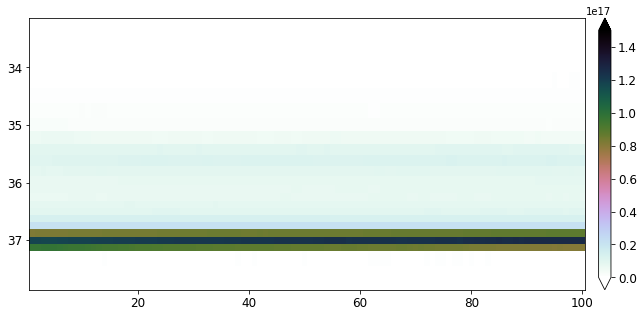

In [18]:
fig = hovmoeller(vol_rho2.sel(sigma2=slice(33,38)), fsize=[12, 5], yincrease=False, cmap='cubehelix_r',
                 vrange=[0,1.5e17])

In [19]:
vol_rho2_anom = vol_rho2 - vol_rho2.mean('year')

In [20]:
sig_upper,sig_lower = 37.1, None # CM4 (AABW) 
#sig_upper,sig_lower = 36.7,37 # CM4 (CDW)
#sig_upper,sig_lower = 37.0, None # ESM4 (AABW) 
#sig_upper,sig_lower = 36.6, 36.9 # ESM4 (CDW) 

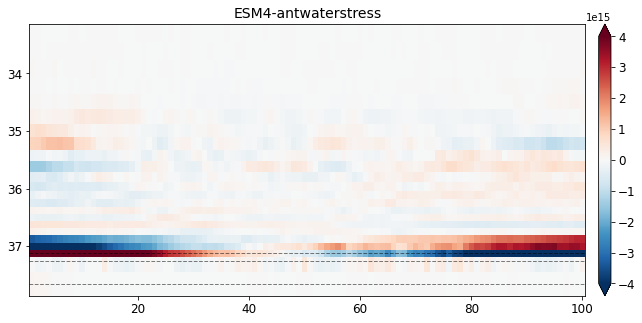

In [21]:
fig, ax = hovmoeller(vol_rho2_anom.sel(sigma2=slice(33,38)), fsize=[12, 5], yincrease=False,
                     vrange=[-4e15,4e15])

for sig in vol_rho2_anom.sel(sigma2=slice(sig_upper,sig_lower)).sigma2.values:
    ax.axhline(y=sig, ls='--', lw=1,c='k',alpha=0.5)
ax.set_title(mod+'-'+exp,fontsize=14)
plt.show()

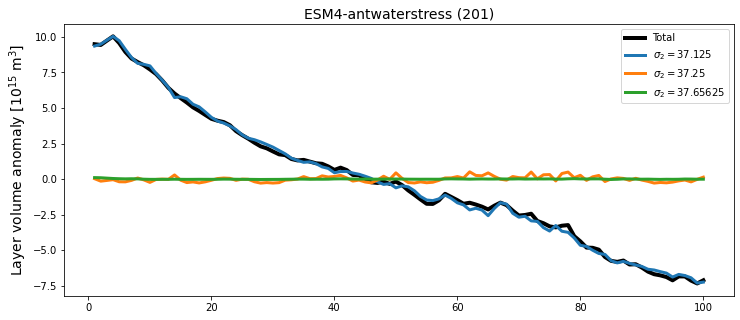

In [22]:
fig, ax = plt.subplots(figsize=[12,5])
(vol_rho2_anom*1e-15).sel(sigma2=slice(sig_upper,sig_lower)).sum('sigma2')\
    .plot(ax=ax,lw=4,c='k',_labels=False,label='Total')
for sig in vol_rho2_anom.sel(sigma2=slice(sig_upper,sig_lower)).sigma2.values:
    (vol_rho2_anom*1e-15).sel(sigma2=sig).plot(ax=ax,lw=3,_labels=False,label='$\sigma_2 = %s$'%str(sig))
ax.legend()
ax.set_ylabel('Layer volume anomaly [10$^{15}$ m$^3$]',fontsize=14)
ax.set_title(mod+'-'+exp,fontsize=14)
ax.set_title('%s-%s'%(mod,exp) if exp=='control' else '%s-%s (%s)'%(mod,exp,str(mem)),fontsize=14)

plt.show()

In [23]:
p = vol_rho2.sel(sigma2=slice(sig_upper,sig_lower),year=slice(int(yr_st),int(yr_ed))).sum('sigma2')\
    .polyfit(dim='year', deg=1)
fit = xr.polyval(vol_rho2.sel(year=slice(int(yr_st),int(yr_ed)))['year'], p.polyfit_coefficients)

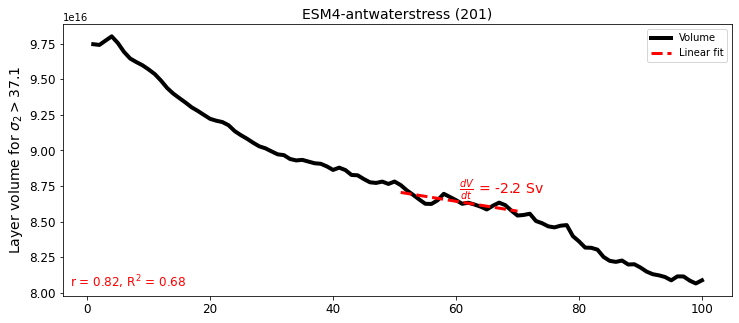

In [24]:
ha, xtxt = 'left', 0.01# right,0.99 / left, 0.01
fig, ax = plt.subplots(figsize=[12,5])
vol_rho2.sel(sigma2=slice(sig_upper,sig_lower)).sum('sigma2').plot(ax=ax,lw=4,c='k',_labels=False,label='Volume')
fit.plot(ax=ax,lw=3,c='r',ls='--',_labels=False,label='Linear fit')
ax.text(fit.year.median(), fit.mean(), r'$\frac{dV}{dt}$ = %.1f Sv'%(p.polyfit_coefficients[0]/(365*24*60*60)/1e6), 
        c='r',horizontalalignment=ha,verticalalignment='bottom',fontsize=14)
ax.text(xtxt, 0.02, 'r = %.2f, R$^2$ = %.2f'\
        %(xr.corr(fit,vol_rho2.sel(sigma2=slice(sig_upper,sig_lower),
                                   year=slice(int(yr_st),int(yr_ed))).sum('sigma2')),
         r2_score(vol_rho2.sel(sigma2=slice(sig_upper,sig_lower),
                               year=slice(int(yr_st),int(yr_ed))).sum('sigma2'),fit)),c='r',
        horizontalalignment=ha, verticalalignment='bottom', transform=ax.transAxes, fontsize=12)

ax.legend()
ax.set_ylabel('Layer volume for $\sigma_2 > %.1f$'%sig_upper,fontsize=14)
#ax.set_ylabel('Layer volume for $%.1f < \sigma_2 < %.1f$'%(sig_upper,sig_lower),fontsize=14)
ax.tick_params(axis='both', which='major', labelsize=12)
ax.set_title('%s-%s'%(mod,exp) if exp=='control' else '%s-%s (%s)'%(mod,exp,str(mem)),fontsize=14)
plt.show()

### Compare variability with surface WMT

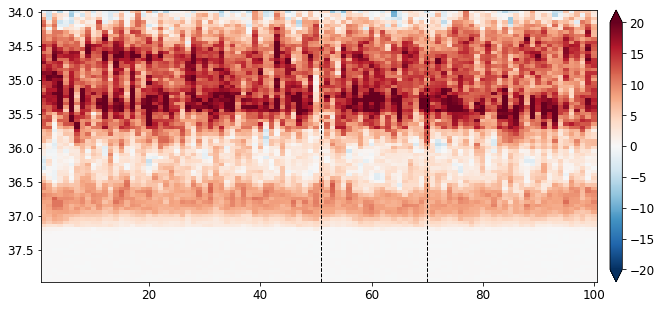

In [25]:
G = ddict['swmt']['heat']
G_ann = G.groupby('time.year').mean('time')*1e-6
fig = hovmoeller(G_ann, fsize=[12, 5], yincrease=False,vrange=[-20,20],vline=[int(yr_st),int(yr_ed)])

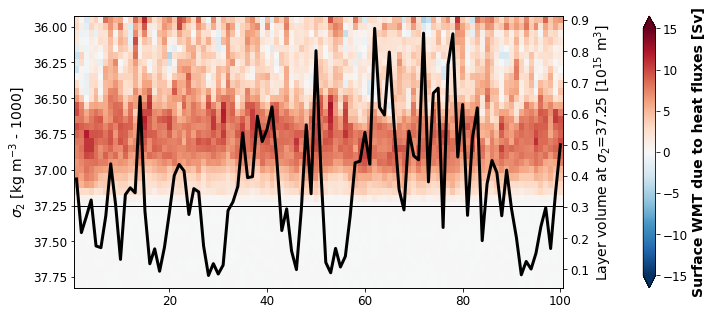

In [26]:
fig, ax = plt.subplots(figsize=[12,5])
p = G_ann.sel(sigma2=slice(35.9,37.8)).T.plot(ax=ax,vmin=-15, vmax=15, cmap='RdBu_r', add_labels=False,
                                              add_colorbar=False,yincrease=False)
ax.tick_params(axis='both', which='major', labelsize=12)
ax.set_ylabel('$\sigma_2$ [kg m$^{-3}$ - 1000]',fontsize=14)
ax.axhline(y=37.25, c = 'k', ls='-', lw=1)

parax = ax.twinx()
(vol_rho2*1e-15).sel(sigma2=37.25,method='nearest').plot(ax=parax,lw=3,c='k',_labels=False)

parax.tick_params(axis='both', which='major', labelsize=12)
parax.set_ylabel('Layer volume at $\sigma_2$=37.25 [10$^{15}$ m$^3$]',fontsize=14)
cb = fig.colorbar(p, orientation='vertical', extend='both', pad=0.12)
cb.set_label(label='Surface WMT due to heat fluxes [Sv]', fontsize=14, weight='bold')
cb.ax.tick_params(labelsize='large')
plt.show()

### Calculate the change in volume
Convert the volume change to units of Sv

In [27]:
tstr = '%sto%s'%(str(ds.time.dt.year[0].values).rjust(4, '0'),str(ds.time.dt.year[-1].values).rjust(4, '0'))
vol_rho2 = xr.open_dataset(outdir+head+'_so_'+tstr+'_vol_rho2_online_lores.nc').volcello

In [28]:
dV = vol_rho2.shift(time=-1)-vol_rho2

# Build xarray Data Array of seconds per year
n_years = len(np.unique(ds.time.dt.year))
dt = xr.DataArray(np.tile(365*24*60*60, n_years), coords = [ds.time], 
                  dims = ['time'], name = 'seconds per year')

# Calculate dV/dt (volume change per second) and convert to Sv
dVdt = dV/dt/1.0e6

In [29]:
# Cumulative sum of volume along density (towards increasingly denser water layers)
integ_layers = dVdt.cumsum('rho2_l') - dVdt.sum('rho2_l')

# The result of the integration over layers is evaluated at the interfaces
# with psi = 0 as the bottom boundary condition for the integration
bottom_condition = xr.zeros_like(integ_layers.isel({'rho2_l': 0}))

# combine bottom condition with data array
#dVdt_int = xr.concat([integ_layers, bottom_condition], dim='rho2_l')
dVdt_int = xr.concat([bottom_condition, integ_layers], dim='rho2_l')

# need to rechunk to new size
dVdt_int = dVdt_int.chunk({'rho2_l': len(dVdt_int['rho2_l'])})

# rename to correct dimension and add correct vertical coordinate
M = -dVdt_int.rename({'rho2_l': 'rho2_i'})
M['rho2_i'] = vars_ds.rho2_i
M.name = 'Storage change'

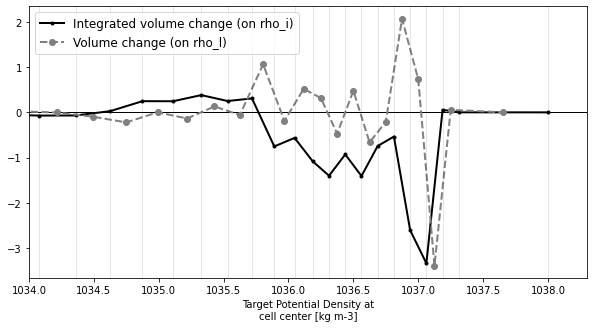

In [30]:
fig, ax = plt.subplots(figsize=(10,5))
ax.axhline(y=0, xmin=0, xmax=1, linewidth=1.0, color = 'k')
M.sel(rho2_i=slice(1033,1038),time=slice(yr_st,yr_ed)).mean('time')\
        .plot(ax=ax, ls='-',lw=2, c='k',label = 'Integrated volume change (on rho_i)',marker='.')
dVdt.sel(rho2_l=slice(1033,1038),time=slice(yr_st,yr_ed)).mean('time')\
        .plot(ax=ax, ls='--',lw=2,c='grey', label = 'Volume change (on rho_l)',marker='o')
ax.legend(loc='upper left', ncol=1, fontsize=12)
for val in vars_ds.rho2_i.values:
    ax.axvline(x=val,c='k',lw=1,alpha=0.1)

ax.set_xlim([1034,1038.3])
plt.show()

In [31]:
fname = head+'_so_%sto%s_dVdt_rho2_online_lores.nc'\
        %(str(M.time.dt.year[0].values).rjust(4, '0'),str(M.time.dt.year[-1].values).rjust(4, '0'))
print('Saving to file:', fname)
M.reset_coords(drop=True).to_dataset().to_netcdf(outdir+fname, format='NETCDF4')

Saving to file: ESM4_antwaterstress_201_so_0001to0100_dVdt_rho2_online_lores.nc


In [32]:
tstr = '%sto%s'%(str(ds.time.dt.year[0].values).rjust(4, '0'),str(ds.time.dt.year[-1].values).rjust(4, '0'))
M = xr.open_dataset(outdir+head+'_so_'+tstr+'_dVdt_rho2_online_lores.nc')['Storage change']

In [33]:
dVdt['sigma2'] = dVdt.rho2_l-1000
dVdt = dVdt.swap_dims({'rho2_l':'sigma2'})
dVdt['year'] = dVdt.time.dt.year
dVdt= dVdt.swap_dims({'time':'year'})

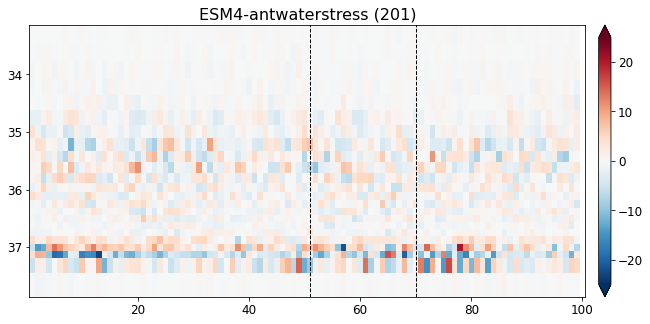

In [34]:
fig = hovmoeller(dVdt.sel(sigma2=slice(33,38)), fsize=[12, 5], yincrease=False,vrange=[-25,25],
                 vline=[int(yr_st),int(yr_ed)],
                 title='%s-%s'%(mod,exp) if exp=='control' else '%s-%s (%s)'%(mod,exp,str(mem)))

In [35]:
M['sigma2'] = M.rho2_i-1000
M = M.swap_dims({'rho2_i':'sigma2'})
M['year'] = M.time.dt.year
M= M.swap_dims({'time':'year'})

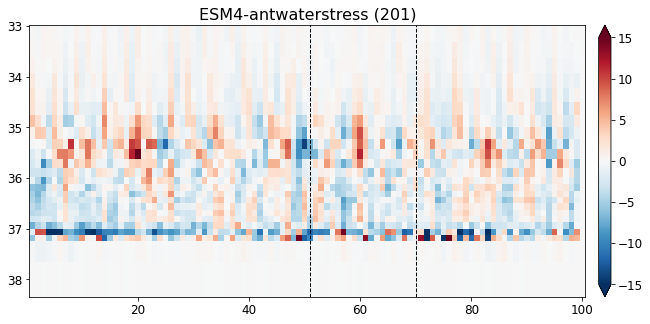

In [36]:
fig = hovmoeller(M.sel(sigma2=slice(33,38)), fsize=[12, 5], yincrease=False,vrange=[-15,15],
                 vline=[int(yr_st),int(yr_ed)],
                 title='%s-%s'%(mod,exp) if exp=='control' else '%s-%s (%s)'%(mod,exp,str(mem)))

In [37]:
smoc = ddict['psi'].sel(rho2_i=slice(1033,1038),yq=slice(None,0)).psi
smoc['sigma2'] = smoc.rho2_i-1000
smoc = smoc.swap_dims({'rho2_i':'sigma2'})
psi = (-smoc).sel(yq=[-30], method='nearest').squeeze()

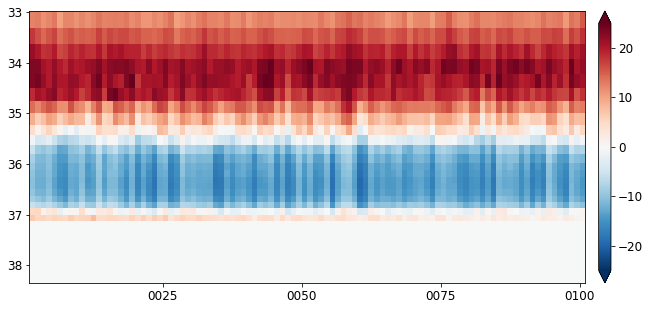

In [38]:
fig = hovmoeller(psi, fsize=[12, 5], yincrease=False,vrange=[-25,25])

In [39]:
smoc_mean = smoc.sel(time=slice(yr_st,yr_ed)).mean('time')
G_mean = ddict['swmt'].total.sel(time=slice(yr_st,yr_ed)).mean('time')*1e-6
psi = (-smoc_mean).sel(yq=[-30], method='nearest').squeeze()
G_interp = G_mean.interp(sigma2=psi.sigma2,kwargs={'fill_value':0})
M_mean = M.sel(sigma2=slice(33,38),year=slice(int(yr_st),int(yr_ed))).mean('year')

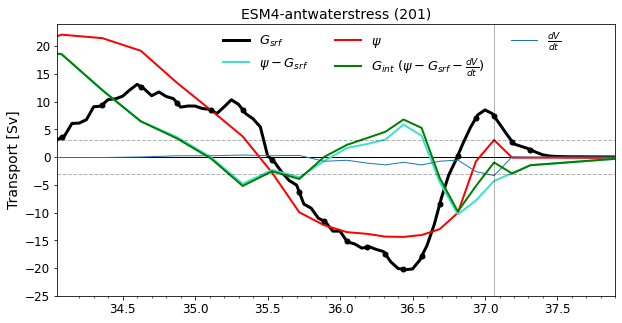

In [40]:
fig, ax = plt.subplots(figsize=(10,5))

ax.axhline(y=0, xmin=0, xmax=1, linewidth=1.0, color = 'k')
l1,=ax.plot(G_mean.sigma2, G_mean, color='k', linestyle='-',lw=3, label = '$G_{srf}$')
l2,=ax.plot(psi.sigma2, psi, color='r', linestyle='-',lw=2, label = '$\psi$')
ax.plot(G_interp.sigma2, G_interp, marker='o',ms=5, c='k', ls='none')
l3,=(psi - G_interp).plot(ax=ax, color='turquoise', linestyle='-', lw=2, label = '$\psi - G_{srf}$',
                          _labels=None)
ax.set_xlim([34.05,37.8])
ax.set_xticks(np.arange(34.2,38,0.1), minor=True)
ax.set_ylim([-25,24])
ax.set_yticks(np.arange(-25,25,5))
 
ax.set_ylabel(r'Transport [Sv]',fontsize=14)
ax.tick_params(axis='both', which='major', labelsize=12)

l4,=M_mean.plot(ax=ax, ls='-',lw=1,label = '$\\frac{dV}{dt}$',_labels=None)
l5,=(psi-G_interp-M_mean).plot(ax=ax, color='g', linestyle='-', lw=2,_labels=None,
                            label='$G_{int}$ ($\psi - G_{srf} - \\frac{dV}{dt}$)')

ax.set_title('%s-%s'%(mod,exp) if exp=='control' else '%s-%s (%s)'%(mod,exp,str(mem)),fontsize=14)

leg1 = ax.legend(handles=[l1,l3,l2,l5,l4], frameon=False, fancybox=False, bbox_to_anchor=(0.6, 1.02), 
                     loc='upper center', ncol=3, fontsize=13)

ax.axhline(y=3, xmin=0, xmax=1, linewidth=1.0, color = 'k',alpha=0.3,ls='--')
ax.axhline(y=-3, xmin=0, xmax=1, linewidth=1.0, color = 'k',alpha=0.3,ls='--')
ax.axvline(x=37.06, ymin=0, ymax=1, linewidth=1.0, color = 'k',alpha=0.3,ls='-')

plt.show()

### Spatial pattern

In [41]:
dVxy = ds_so.volcello.shift(time=-1)-ds_so.volcello

# Build xarray Data Array of seconds per year
n_years = len(np.unique(ds.time.dt.year))
dt = xr.DataArray(np.tile(365*24*60*60, n_years), coords = [ds.time], 
                  dims = ['time'], name = 'seconds per year')

# Calculate dV/dt (volume change per second) and convert to Sv
dVdtxy = dVxy/dt/1.0e6

In [42]:
# Cumulative sum of volume along density (towards increasingly denser water layers)
integ_layers = dVdtxy.cumsum('rho2_l') - dVdtxy.sum('rho2_l')

# The result of the integration over layers is evaluated at the interfaces
# with psi = 0 as the bottom boundary condition for the integration
bottom_condition = xr.zeros_like(integ_layers.isel({'rho2_l': 0}))

# combine bottom condition with data array
#dVdt_int = xr.concat([integ_layers, bottom_condition], dim='rho2_l')
dVdtxy_int = xr.concat([bottom_condition, integ_layers], dim='rho2_l')

# need to rechunk to new size
dVdtxy_int = dVdtxy_int.chunk({'rho2_l': len(dVdtxy_int['rho2_l'])})

# rename to correct dimension and add correct vertical coordinate
Mxy = -dVdtxy_int.rename({'rho2_l': 'rho2_i'})
Mxy['rho2_i'] = vars_ds.rho2_i
Mxy.name = 'Storage change'

In [43]:
Mxy['sigma2'] = Mxy.rho2_i-1000
Mxy = Mxy.swap_dims({'rho2_i':'sigma2'})

In [47]:
with ProgressBar():
    dVdtxy_map = Mxy.sel(sigma2=37.06, method='nearest').sel(time=slice(yr_st,yr_ed)).mean('time').load()

[########################################] | 100% Completed | 16.4s


In [48]:
ds_so['dVdtxy'] = dVdtxy_map*1e3

In [49]:
from plot import cartopy_map_so

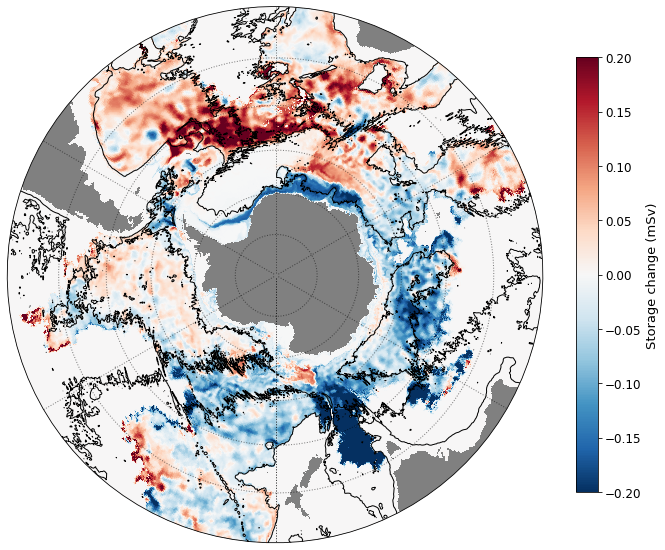

In [50]:
fig, ax = cartopy_map_so(ds_so,'dVdtxy', lat=-30, fsize=[12,10], drawGrid=True,cmap='RdBu_r',vrange=[-0.2,0.2],
                        blevels=[4000.0],cb_label='Storage change (mSv)')#,balpha=0.3)

In [57]:
dVdtxy_map.sum()

<xarray.DataArray 'Storage change' ()>
array(-4.05711745)
Coordinates:
    rho2_i   float64 1.037e+03
    sigma2   float64 37.06

In [58]:
M_mean.sel(sigma2=37, method="nearest")

<xarray.DataArray 'Storage change' ()>
array(-4.05712268)
Coordinates:
    rho2_i   float64 1.037e+03
    sigma2   float64 37.06

### Zonal sum of storage change

In [44]:
volcello = ds_so.volcello.sel(time=slice(yr_st,yr_ed))

# Thickness mapped to rho2 
thk = (volcello/ds_so.areacello).mean('time')
#thk = ds.thkcello.mean('time')

# Cumulative sum of thickness to get the time averaged depth of an isopycnal 
#zrho = thk.mean('x').cumsum('rho2_l')
integ_layers = thk.mean('x').cumsum('rho2_l')
bottom_condition = xr.zeros_like(integ_layers.isel({'rho2_l': 0}))
zrho_raw = xr.concat([bottom_condition, integ_layers], dim='rho2_l') # preferred
zrho_raw = zrho_raw.chunk({'rho2_l': len(zrho_raw['rho2_l'])})
zrho = zrho_raw.rename({'rho2_l': 'rho2_i'}).transpose('rho2_i','y')

zrho['rho2_i'] = vars_ds.rho2_i
zrho.name = 'Depth'

In [45]:
M_sumx = Mxy.sum('x').transpose('time','sigma2','y')

In [46]:
zrho['sigma2'] = zrho.rho2_i-1000
zrho = zrho.swap_dims({'rho2_i':'sigma2'})

In [47]:
M_sumx.coords['depth'] = zrho

In [48]:
with ProgressBar():
    M_sumx_mean = M_sumx.sel(time=slice(yr_st,yr_ed)).mean('time').load()

[########################################] | 100% Completed | 15.4s


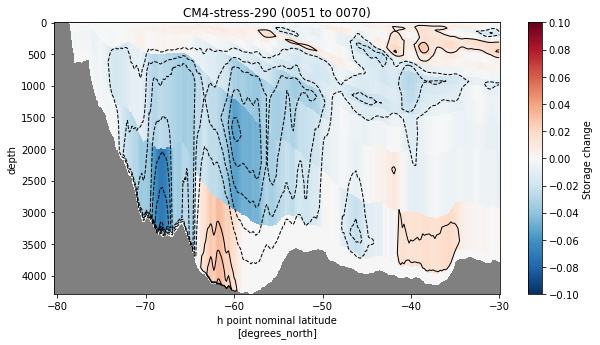

In [49]:
fig, ax = plt.subplots(figsize=(10,5))
M_sumx_mean.plot(ax=ax,x='y', y='depth',yincrease=False,vmin=-0.1,vmax=0.1,cmap='RdBu_r',
                 cbar_kwargs={'ticks': np.linspace(-0.1,0.1,11)})
M_sumx_mean.plot.contour(ax=ax, x='y', y='depth', yincrease=False, 
                      levels=np.concatenate([np.arange(-0.1,0,0.01),np.arange(0.01,0.11,0.01)]), 
                      colors='k', linewidths=1)
ax.set_facecolor('gray')
ax.set_title(mod+'-'+exp+'-'+str(mem)+' ('+yr_st+' to '+yr_ed+')')
plt.show()

## Storage change streamfunction

In [10]:
north = -30.0
#lats = grid_ds.sel(yq=slice(None,grid_ds.sel(yq=[north], method='nearest').squeeze().yq.values)).yq.values
lats = np.linspace(-80,-30,51)

In [11]:
n_years = len(np.unique(ds.time.dt.year))
dt = xr.DataArray(np.tile(365*24*60*60, n_years), coords = [ds.time], dims = ['time'], name = 'seconds per year')
Ms = []
for latn in lats:
    if latn<grid_ds.yh[0]:
        continue
    print(latn)
    ds_so = ds.drop_dims('nv').where(ds.lat<latn,drop=True)
    ds_so['time_bnds'] = ds.time_bnds
    
    vol_rho2 = ds_so.volcello.sum(dim=['x','y'])
    dV = vol_rho2.shift(time=-1)-vol_rho2
    
    # Calculate dV/dt (volume change per second) and convert to Sv
    dVdt = dV/dt/1.0e6
    
    # Cumulative sum of volume along density (towards increasingly denser water layers)
    integ_layers = dVdt.cumsum('rho2_l') - dVdt.sum('rho2_l')
    bottom_condition = xr.zeros_like(integ_layers.isel({'rho2_l': 0}))
    dVdt_int = xr.concat([bottom_condition, integ_layers], dim='rho2_l')
    dVdt_int = dVdt_int.chunk({'rho2_l': len(dVdt_int['rho2_l'])})
    
    M = -dVdt_int.rename({'rho2_l': 'rho2_i'})
    M['rho2_i'] = vars_ds.rho2_i
    M.name = 'dVdt'
    M['y'] = latn

    Ms.append(M)

-77.0
-76.0
-75.0
-74.0
-73.0
-72.0
-71.0
-70.0
-69.0
-68.0
-67.0
-66.0
-65.0
-64.0
-63.0
-62.0
-61.0
-60.0
-59.0
-58.0
-57.0
-56.0
-55.0
-54.0
-53.0
-52.0
-51.0
-50.0
-49.0
-48.0
-47.0
-46.0
-45.0
-44.0
-43.0
-42.0
-41.0
-40.0
-39.0
-38.0
-37.0
-36.0
-35.0
-34.0
-33.0
-32.0
-31.0
-30.0


In [12]:
dVdt = xr.concat(Ms, dim='y').transpose('time','rho2_i','y')

In [13]:
dsM = dVdt.reset_coords(drop=True).to_dataset(name='dVdt')

In [14]:
nrho = 'lores'
fname = head+'_so_%sto%s_dVdt_streamfunction_rho2_online_%s.nc'\
        %(str(dsM.time.dt.year[0].values).rjust(4, '0'),str(dsM.time.dt.year[-1].values).rjust(4, '0'),nrho)
print('Saving to file:', fname)
with ProgressBar():
    dsM.to_netcdf(outdir+fname, format='NETCDF4')

Saving to file: ESM4_control_so_0101to0300_dVdt_streamfunction_rho2_online_lores.nc
[########################################] | 100% Completed |  3min 57.6s


In [15]:
dVdt_rho2 = xr.open_dataset(outdir+fname).dVdt

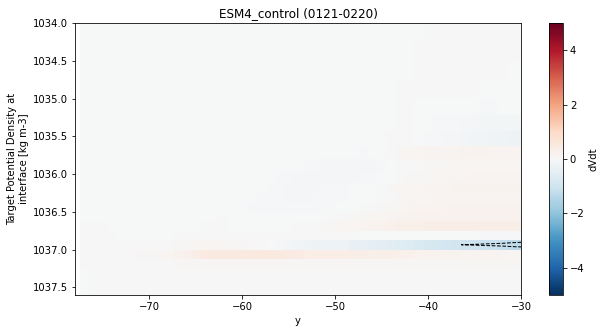

In [16]:
fig, ax = plt.subplots(figsize=(10,5))
dVdt_rho2.sel(time=slice(yr_st,yr_ed)).mean('time').sel(rho2_i=slice(1034,1038))\
    .plot(ax=ax, yincrease=False,cmap='RdBu_r',vmin=-5,vmax=5)
dVdt_rho2.sel(time=slice(yr_st,yr_ed)).mean('time').sel(rho2_i=slice(1034,1038))\
    .plot.contour(ax=ax, yincrease=False, levels=np.concatenate([np.arange(-5,0,1),np.arange(1,6,1)]), colors='k', linewidths=1)
ax.set_xlim((-78,-30))
ax.set_ylim((1037.6,1034))
ax.set_title(head+' (%s-%s)'%(yr_st,yr_ed))
plt.show()

In [17]:
M = dVdt_rho2.sel(y=-30, method='nearest').squeeze()
M['sigma2'] = M.rho2_i-1000
M = M.swap_dims({'rho2_i':'sigma2'})
M['year'] = M.time.dt.year
M= M.swap_dims({'time':'year'})
M_mean = M.sel(sigma2=slice(33,38),year=slice(int(yr_st),int(yr_ed))).mean('year')

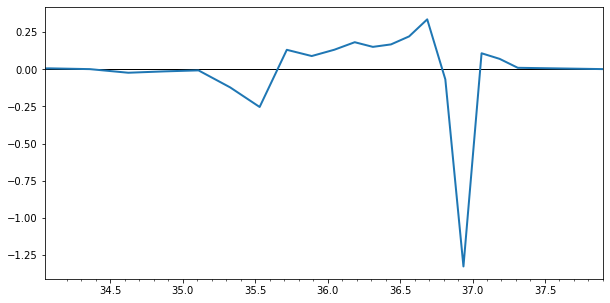

In [18]:
fig, ax = plt.subplots(figsize=(10,5))
ax.axhline(y=0, xmin=0, xmax=1, linewidth=1.0, color = 'k')
l4,=M_mean.plot(ax=ax, ls='-',lw=2,label = '$\\frac{dV}{dt}$',_labels=None)
ax.set_xlim([34.05,37.8])
ax.set_xticks(np.arange(34.2,38,0.1), minor=True)
#ax.set_ylim([-24,24])
#ax.set_yticks(np.arange(-20,25,5))
plt.show()

In [20]:
north = -30.0
#lats = grid_ds.sel(yq=slice(None,grid_ds.sel(yq=[north], method='nearest').squeeze().yq.values)).yq.values
lats = np.linspace(-80,-30,51)
nrho = 'lores'

for mod in ['CM4', 'ESM4']:
    for exp in ['antwater', 'stress', 'antwaterstress']:
        for mem in (['251', '290', '332'] if mod=='CM4' else ['101', '151', '201']):
            
            if mod=='CM4':
                subdir = 'CM4_piControl_C'
            elif mod=='ESM4':
                subdir = 'ESM4_piControl_D'
            
            pp = 'ocean_annual_rho2'
            fafdir = '%s_faf%s_%s'%(subdir,exp,str(mem) if mod=='CM4' else str(mem))
            full_path = os.path.join(rootdir,subdir,pp) if exp=='control' else os.path.join(rootdir,fafdir,pp)
            
            print('Loading '+full_path)
            vars_ds = xr.open_mfdataset(full_path+'/'+pp+'.*.*.nc',use_cftime=True, 
                                        drop_variables=['average_DT','average_T1','average_T2'])
            
            pp = 'ocean_monthly'
            if subdir[:3] == 'CM4':
                grid_ds = xr.open_dataset(rootdir+'CM4_piControl_C/'+pp+'/'+pp+'.static.nc')
            elif subdir[:3] == 'ESM':
                grid_ds = xr.open_dataset(rootdir+'ESM4_piControl_D/'+pp+'/'+pp+'.static.nc')
                
            ds = preprocessing(vars_ds, grid_ds, decode_times=False, verbose=False)
            
            n_years = len(np.unique(ds.time.dt.year))
            dt = xr.DataArray(np.tile(365*24*60*60, n_years), coords = [ds.time],
                              dims = ['time'], name = 'seconds per year')
            
            print('Calculate streamfunction')
            Ms = []
            for latn in lats:
                if latn<grid_ds.yh[0]:
                    continue
                
                ds_so = ds.drop_dims('nv').where(ds.lat<latn,drop=True)
                ds_so['time_bnds'] = ds.time_bnds
                
                vol_rho2 = ds_so.volcello.sum(dim=['x','y'])
                dV = vol_rho2.shift(time=-1)-vol_rho2
                
                # Calculate dV/dt (volume change per second) and convert to Sv
                dVdt = dV/dt/1.0e6
                
                # Cumulative sum of volume along density (towards increasingly denser water layers)
                integ_layers = dVdt.cumsum('rho2_l') - dVdt.sum('rho2_l')
                bottom_condition = xr.zeros_like(integ_layers.isel({'rho2_l': 0}))
                dVdt_int = xr.concat([bottom_condition, integ_layers], dim='rho2_l')
                dVdt_int = dVdt_int.chunk({'rho2_l': len(dVdt_int['rho2_l'])})
                
                M = -dVdt_int.rename({'rho2_l': 'rho2_i'})
                M['rho2_i'] = vars_ds.rho2_i
                M.name = 'dVdt'
                M['y'] = latn
                Ms.append(M)
                
            dVdt = xr.concat(Ms, dim='y').transpose('time','rho2_i','y')
            print(dVdt)
            
            dsM = dVdt.reset_coords(drop=True).to_dataset(name='dVdt')
            print(str(dsM.time.values[0])[:10],'to',str(dsM.time.values[-1])[:10])
            
            head = '%s_%s'%(mod,exp) if exp=='control' else '%s_%s_%s'%(mod,exp,str(mem))
            fname = head+'_so_%sto%s_dVdt_streamfunction_rho2_online_%s.nc'\
                    %(str(dsM.time.dt.year[0].values).rjust(4, '0'),
                      str(dsM.time.dt.year[-1].values).rjust(4, '0'),nrho)
            
            print('Saving to file:', fname)
            with ProgressBar():
                dsM.to_netcdf(outdir+fname, format='NETCDF4')

Loading /scratch/gpfs/jt7058/GFDL/fafmip/raw/CM4_piControl_C_fafantwater_251/ocean_annual_rho2
Calculate streamfunction
<xarray.DataArray 'dVdt' (time: 100, rho2_i: 36, y: 51)>
dask.array<transpose, shape=(100, 36, 51), dtype=float64, chunksize=(1, 36, 1), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) object 0001-07-02 12:00:00 ... 0100-07-02 12:00:00
  * rho2_i   (rho2_i) float64 999.5 1.028e+03 1.029e+03 ... 1.037e+03 1.038e+03
  * y        (y) float64 -80.0 -79.0 -78.0 -77.0 ... -33.0 -32.0 -31.0 -30.0
0001-07-02 to 0100-07-02
Saving to file: CM4_antwater_251_so_0001to0100_dVdt_streamfunction_rho2_online_lores.nc
[########################################] | 100% Completed |  7min 41.6s
Loading /scratch/gpfs/jt7058/GFDL/fafmip/raw/CM4_piControl_C_fafantwater_290/ocean_annual_rho2
Calculate streamfunction
<xarray.DataArray 'dVdt' (time: 70, rho2_i: 36, y: 51)>
dask.array<transpose, shape=(70, 36, 51), dtype=float64, chunksize=(1, 36, 1), chunktype=numpy.ndarray>
Coordinate

[########################################] | 100% Completed |  1min 21.4s
Loading /scratch/gpfs/jt7058/GFDL/fafmip/raw/ESM4_piControl_D_fafstress_101/ocean_annual_rho2
Calculate streamfunction
<xarray.DataArray 'dVdt' (time: 85, rho2_i: 36, y: 48)>
dask.array<transpose, shape=(85, 36, 48), dtype=float64, chunksize=(1, 36, 1), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) object 0101-07-02 12:00:00 ... 0185-07-02 12:00:00
  * rho2_i   (rho2_i) float64 999.5 1.028e+03 1.029e+03 ... 1.037e+03 1.038e+03
  * y        (y) float64 -77.0 -76.0 -75.0 -74.0 ... -33.0 -32.0 -31.0 -30.0
0101-07-02 to 0185-07-02
Saving to file: ESM4_stress_101_so_0101to0185_dVdt_streamfunction_rho2_online_lores.nc
[########################################] | 100% Completed |  1min 36.8s
Loading /scratch/gpfs/jt7058/GFDL/fafmip/raw/ESM4_piControl_D_fafstress_151/ocean_annual_rho2
Calculate streamfunction
<xarray.DataArray 'dVdt' (time: 100, rho2_i: 36, y: 48)>
dask.array<transpose, shape=(100, 36, 48), d

### Volume change

In [4]:
import os
rootdir = '/scratch/gpfs/jt7058/GFDL/fafmip/raw/'
subdir = 'CM4_piControl_C'
rho2_i = xr.open_dataset(os.path.join(rootdir,subdir,'ocean_annual_rho2')\
                       +'/ocean_annual_rho2.0251-0255.vmo.nc').rho2_i.sel(rho2_i=slice(1033,1038)).values
#dsig2 = xr.DataArray(np.diff(rho2_i), coords = [psi.sigma2], dims = ['sigma2'], name = 'dsigma2')

In [15]:
dset = '_vol_rho2_online_lores'
ddict_vol = {m:{} for m in ['CM4','ESM4']}

for m in ddict_vol:
    tstr = '0251to0395' if m=='CM4' else '0101to0270'
    ddict_exp = {e:{} for e in ['control','antwater','stress','antwaterstress']}
    for e in ddict_exp:
        files = glob.glob(outdir+'%s_%s_so_*'%(m,e)+dset+'.nc')
        
        if len(files)>1:
            print('WARNING: More than one file. Please specify.')
            print('Loading '+files[0])
        elif len(files)==0:
            print('ERROR: No file available for '+m+'-'+e)
            ddict_exp[e] = []
            continue
        
        ddict_exp[e] = xr.open_dataset(files[0])
            
    ddict_vol[m] = ddict_exp

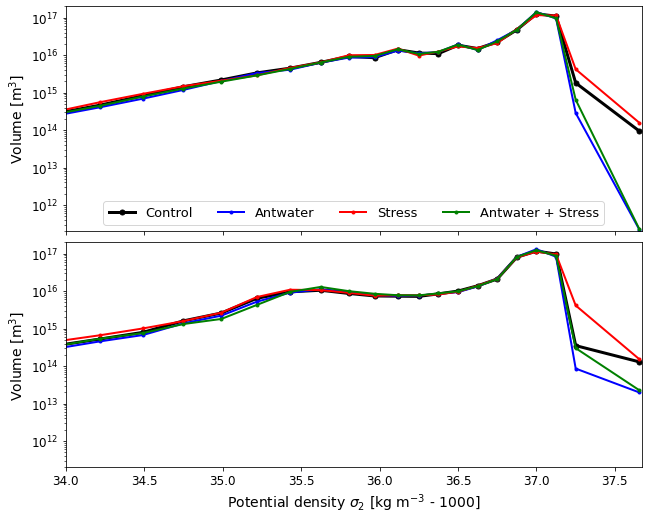

In [58]:
cstr = ['b','r','g']

fig, axs = plt.subplots(2, 1, sharex=False, figsize=(10,8))
fig.subplots_adjust(left=0.1, right=0.9, bottom=0.1, top=0.9,hspace = 0.05)

for i, m in enumerate(ddict_vol):
    
    yr_st,yr_ed = ('0281','0380') if m=='CM4' else ('0121','0220')
    
    vol_rho2 = ddict_vol[m]['control'].volcello
    vol_rho2['sigma2'] = vol_rho2.rho2_l-1000
    vol_rho2 = vol_rho2.swap_dims({'rho2_l':'sigma2'})
    vol_rho2['year'] = vol_rho2.time.dt.year
    vol_rho2= vol_rho2.swap_dims({'time':'year'})

    vol_rho2.sel(year=slice(int(yr_st),int(yr_ed))).mean('year')\
        .plot(ax=axs[i],c='k',lw=3,marker='o',ms=5,label='Control')
    #print(m,yr_st,yr_ed)
    for j, e in enumerate(list(ddict_vol[m].keys())[1:]):
        yr_st,yr_ed = ('0051','0070') if m=='CM4' else ('0151','0170') 
        #print(e,yr_st,yr_ed,cstr[j])
        
        vol_rho2 = ddict_vol[m][e].volcello
        vol_rho2['sigma2'] = vol_rho2.rho2_l-1000
        vol_rho2 = vol_rho2.swap_dims({'rho2_l':'sigma2'})
        vol_rho2['year'] = vol_rho2.time.dt.year
        vol_rho2= vol_rho2.swap_dims({'time':'year'})
        vol_rho2.sel(year=slice(int(yr_st),int(yr_ed))).mean('year')\
            .plot(ax=axs[i],c=cstr[j],lw=2,marker='o',ms=3,
                  label=e[:8].capitalize()+' + '+e[8:].capitalize() if e=='antwaterstress' else e.capitalize())
        
    axs[i].set_yscale('log')
    axs[i].set_xlim([34, 37.67])
    axs[i].set_ylim([2e11, 2e17])
    axs[i].set_ylabel(r'Volume [m$^3$]',fontsize=14)
    axs[i].tick_params(axis='both', which='major', labelsize=12)
    
axs[0].legend(frameon=True, fancybox=True, loc='lower center', ncol=4, fontsize=13)
axs[1].set_xlabel(r'Potential density $\sigma_2$ [kg m$^{-3}$ - 1000]',fontsize=14)
axs[0].set_xticklabels([])

#plt.savefig('/home/jt7058/figure.png', dpi=None, facecolor='w', edgecolor='w',
#            orientation='portrait', format='png',transparent=False, bbox_inches='tight', pad_inches=0.1)
plt.show()

In [22]:
vol_rho2 = ddict_vol['ESM4']['control'].volcello
yr_st,yr_ed = '0121','0220'

In [19]:
vol_rho2['sigma2'] = vol_rho2.rho2_l-1000
vol_rho2 = vol_rho2.swap_dims({'rho2_l':'sigma2'})
vol_rho2['year'] = vol_rho2.time.dt.year
vol_rho2= vol_rho2.swap_dims({'time':'year'})

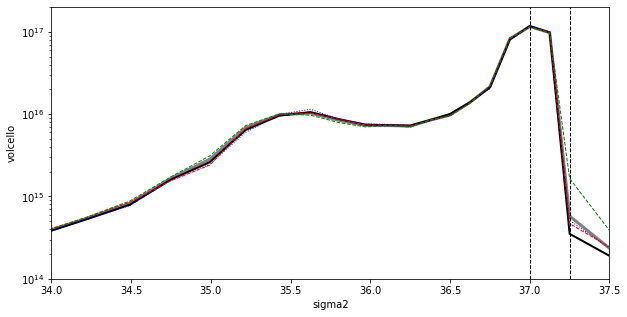

In [20]:
fig, ax = plt.subplots(figsize=(10,5))
vol_rho2.mean('year').plot(ax=ax,c='grey',lw=3,label='')
vol_rho2.sel(year=slice(int(yr_st),int(yr_ed))).mean('year').plot(ax=ax,c='k',lw=2)
vol_rho2.sel(year=slice(int(yr_st),int(yr_st)+10)).mean('year').plot(ax=ax,c='b',lw=1,ls=':')
vol_rho2.sel(year=slice(int(yr_ed)-10,int(yr_ed))).mean('year').plot(ax=ax,c='r',lw=1,ls='--')
vol_rho2.sel(year=slice(241,250)).mean('year').plot(ax=ax,c='g',lw=1,ls='--') # ESM4
#vol_rho2.sel(year=slice(331,340)).mean('year').plot(ax=ax,c='g',lw=1,ls='--') # CM4
ax.set_yscale('log')
ax.set_xlim([34, 37.5])
ax.set_ylim([1e14, 2e17])
ax.axvline(x=37.25, c = 'k', ls='--', lw=1)
ax.axvline(x=37.0, c = 'k', ls='--', lw=1)

plt.show()